# Лабораторная работа №4. Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

**Цель лабораторной работы:** изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

**Требования к отчету:**
отчет по лабораторной работе должен содержать:
- титульный лист;
- описание задания;
- текст программы;
- экранные формы с примерами выполнения программы.

# Задание:
1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8. Постройте кривые обучения и валидации.

# Текстовое описание набора данных

Используется набор данных, использующий данные химического анализа для установления происхождения вина: https://archive.ics.uci.edu/ml/datasets/Wine

Эти данные являются результатами химического анализа вин, выращенных в одном регионе Италии, но полученных из трех различных сортов. В результате анализа было определено 13 компонентов, содержащихся в каждом из трех видов вин. 

Датасет содержит следующие колонки:
- Алкоголь 
- Яблочная кислота 
- Зола 
- Щелочность золы 
- Магний 
- Всего фенолов 
- Флаваноиды 
- Нефлаваноидные фенолы 
- Проантоцианы 
- Интенсивность цвета 
- Оттенок 
- OD280 / OD315 (разбавленность вина) 
- Пролин 

## 1. Выбор датасета

In [7]:
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [8]:
wine = load_wine()

In [9]:
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])
data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


## 3. Разделение выборки на обучающую и тестовую

In [10]:
# Разделение выборки на обучающую и тестовую
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, wine.target, test_size=0.5, random_state=1)

## 4. Обучение модели ближайших соседей

In [32]:
# 50 ближайших соседей
cl1_1 = KNeighborsClassifier(n_neighbors=50)
cl1_1.fit(wine_X_train, wine_y_train)
target1_0 = cl1_1.predict(wine_X_train)
target1_1 = cl1_1.predict(wine_X_test)
accuracy_score(wine_y_train, target1_0), accuracy_score(wine_y_test, target1_1)

(0.6741573033707865, 0.7191011235955056)

In [33]:
# 5 ближайших соседей
cl1_1 = KNeighborsClassifier(n_neighbors=5)
cl1_1.fit(wine_X_train, wine_y_train)
target1_0 = cl1_1.predict(wine_X_train)
target1_1 = cl1_1.predict(wine_X_test)
accuracy_score(wine_y_train, target1_0), accuracy_score(wine_y_test, target1_1)

(0.8426966292134831, 0.7078651685393258)

In [34]:
# 1 ближайший сосед - "условное" переобучение
cl1_1 = KNeighborsClassifier(n_neighbors=1)
cl1_1.fit(wine_X_train, wine_y_train)
target1_0 = cl1_1.predict(wine_X_train)
target1_1 = cl1_1.predict(wine_X_test)
accuracy_score(wine_y_train, target1_0), accuracy_score(wine_y_test, target1_1)

(1.0, 0.6966292134831461)

## 5. Построение модели и оценка качества модели с использованием кросс-валидации

In [36]:
# вызов функции cross_val_score
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         wine.data, wine.target, cv=3)

In [37]:
# Значение метрики accuracy для 3 фолдов
scores

array([0.56666667, 0.6440678 , 0.72881356])

In [38]:
# Усредненное значение метрики accuracy для 3 фолдов
np.mean(scores)

0.6465160075329566

In [39]:
# использование метрики f1
# https://scikit-learn.org/stable/modules/model_evaluation.html
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         wine.data, wine.target, cv=3,
                        scoring='f1_weighted')
scores, np.mean(scores)

(array([0.51069094, 0.6198816 , 0.6798559 ]), 0.6034761483135361)

### Стратегия K-fold

In [40]:
# Возвращаются индексы элементов
X = ["a", "b", "c"]
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[1 2] [0]
[0 2] [1]
[0 1] [2]


In [41]:
X = range(12)
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


In [45]:
kf = KFold(n_splits=5)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         wine.data, wine.target, scoring='f1_weighted', 
                         cv=kf)
scores

array([0.92537313, 0.86969697, 0.77966102, 0.65924812, 0.        ])

In [46]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [48]:
kf = KFold(n_splits=5)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        wine.data, wine.target, scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

d:\документы\магистратура\2 семестр\ммо + пис\лабы\virtualenvs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\документы\магистратура\2 семестр\ммо + пис\лабы\virtualenvs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\документы\магистратура\2 семестр\ммо + пис\лабы\virtualenvs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

{'fit_time': array([0.00205064, 0.00202656, 0.00099635, 0.00099587, 0.00109267]),
 'score_time': array([0.00789881, 0.00797439, 0.01293206, 0.0089767 , 0.00289536]),
 'test_precision': array([1.        , 0.90939153, 1.        , 0.69659864, 0.        ]),
 'train_precision': array([0.87898859, 0.89700325, 0.89859407, 0.87809081, 0.90796956]),
 'test_recall': array([0.86111111, 0.83333333, 0.63888889, 0.68571429, 0.        ]),
 'train_recall': array([0.85915493, 0.88028169, 0.88028169, 0.86013986, 0.9020979 ]),
 'test_f1': array([0.92537313, 0.86969697, 0.77966102, 0.65924812, 0.        ]),
 'train_f1': array([0.85579923, 0.87555637, 0.87794358, 0.85195658, 0.89135438])}

### Стратегия Repeated K-fold

In [49]:
X = range(12)
kf = RepeatedKFold(n_splits=3, n_repeats=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[0 1 2 3 4 7 8 9] [ 5  6 10 11]
[ 1  3  4  5  6  9 10 11] [0 2 7 8]
[ 0  2  5  6  7  8 10 11] [1 3 4 9]
[ 0  1  2  4  5  8  9 11] [ 3  6  7 10]
[ 0  2  3  4  5  6  7 10] [ 1  8  9 11]
[ 1  3  6  7  8  9 10 11] [0 2 4 5]


### Стратегия ShuffleSplit

In [50]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = ShuffleSplit(n_splits=5, test_size=0.25)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 5  6  9 10 11  2  0  3  1] [4 8 7]
[ 2  0  4  6 10  8  5  3  7] [11  9  1]
[ 8  0 10  5 11  7  3  4  1] [6 2 9]
[ 1  5  4  2 11  8  7  6  9] [10  3  0]
[10  5  8  0 11  2  3  9  1] [4 7 6]


## 6. Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

In [51]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [53]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(wine_X_train, wine_y_train)

Wall time: 215 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [54]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00056725, 0.00019298, 0.00078659, 0.00080194, 0.0010088 ,
        0.0009975 , 0.00079803, 0.0006227 , 0.00059862, 0.00059834]),
 'std_fit_time': array([5.08172216e-04, 3.85951996e-04, 2.61900108e-04, 4.01170744e-04,
        1.73226480e-05, 3.50402318e-07, 3.99017362e-04, 4.60492618e-04,
        4.88772518e-04, 4.88538707e-04]),
 'mean_score_time': array([0.00242505, 0.00175667, 0.0027895 , 0.00279202, 0.00257635,
        0.00343604, 0.0031909 , 0.00296717, 0.00279188, 0.00302725]),
 'std_score_time': array([8.75964403e-04, 6.78387378e-04, 4.37183878e-04, 3.98898854e-04,
        4.88489705e-04, 5.27256581e-04, 3.98922166e-04, 4.86613196e-05,
        3.98635950e-04, 4.36428188e-05]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_

In [55]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [56]:
# Лучшее значение метрики
clf_gs.best_score_

0.7189542483660132

In [57]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 15}

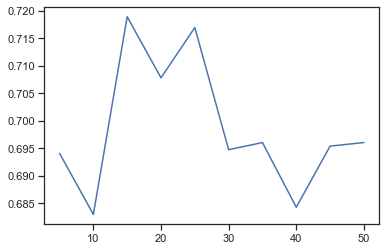

In [58]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

## 7. Обучение модели и оценка качества с учетом подобранных гиперпараметров

In [59]:
clf_gs.best_estimator_.fit(wine_X_train, wine_y_train)
target2_0 = clf_gs.best_estimator_.predict(wine_X_train)
target2_1 = clf_gs.best_estimator_.predict(wine_X_test)

In [61]:
# Новое качество модели
accuracy_score(wine_y_train, target2_0), accuracy_score(wine_y_test, target2_1)

(0.7078651685393258, 0.7078651685393258)

In [62]:
# Качество модели до подбора гиперпараметров
accuracy_score(wine_y_train, target1_0), accuracy_score(wine_y_test, target1_1)

(1.0, 0.6966292134831461)

## 8.Построение кривых обучения и валидации

### Построение кривых обучения

In [71]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'd:\\документы\\магистратура\\2 семестр\\ммо + пис\\лабы\\virtualenvs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

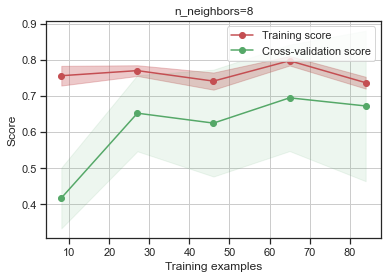

In [75]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=8), 'n_neighbors=8', 
                    wine_X_train, wine_y_train, cv=20)

### Построение кривой валидации

In [68]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'd:\\документы\\магистратура\\2 семестр\\ммо + пис\\лабы\\virtualenvs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

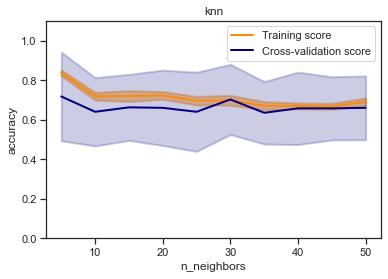

In [70]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      wine_X_train, wine_y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=20, scoring="accuracy")